In [2]:
import os
thread_limit = 16

# Limit threads BEFORE importing numpy
# so I don't crash tolva
os.environ["OMP_NUM_THREADS"] = str(thread_limit)
os.environ["OPENBLAS_NUM_THREADS"] = str(thread_limit)
os.environ["MKL_NUM_THREADS"] = str(thread_limit)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(thread_limit)
os.environ["NUMEXPR_NUM_THREADS"] = str(thread_limit)

In [3]:
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
import h5py
import scipy.sparse as sp
import pandas as pd
import scanpy as sc

In [4]:
# Where data is stored
outdir = "/mnt/data1/10XvParse/Analysis_3/"

# method names
names = ['10x', 'polyT', 'randO', 'parse']
titles = ['10X Genomics', 'Parse PolyT', 'Parse Random Oligo', 'Parse']
samples = ['H1', 'H2']

In [ ]:
def cellBender(iter):
    name = iter[0]
    mod = iter[1]

    m_string = ""
    if mod:
        m_string = "_modified"

    for sample in samples:
        input = f"{outdir}sample_{name}_{sample}_out/counts_unfiltered{m_string}/adata.h5ad"
        output = f"{outdir}cellbender/{name}_{sample}.h5"
        !cellbender remove-background --input {input} --output {output} --cpu-threads 8

with multiprocessing.Pool(processes=1) as pool:
    iter = zip(names,
               [False, False, False, True])
    print(pool.map(cellBender, iter))
    print("done")

cellbender:remove-background: Command:
cellbender remove-background --input /mnt/data1/10XvParse/Analysis_3/sample_10x_H2_out/counts_unfiltered/adata.h5ad --output /mnt/data1/10XvParse/Analysis_3/cellbender/10x_H2.h5 --cpu-threads 8
cellbender:remove-background: CellBender 0.3.2
cellbender:remove-background: (Workflow hash c0c40fcd06)
cellbender:remove-background: 2025-09-08 09:53:06
cellbender:remove-background: Running remove-background
cellbender:remove-background: Loading data from /mnt/data1/10XvParse/Analysis_3/sample_10x_H2_out/counts_unfiltered/adata.h5ad
cellbender:remove-background: AnnData format
cellbender:remove-background: Using `.X` for count data.
cellbender:remove-background: Features in dataset: 39546 NA
cellbender:remove-background: Trimming features for inference.
cellbender:remove-background: 23429 features have nonzero counts.
cellbender:remove-background: Prior on counts for cells is 2760
cellbender:remove-background: Prior on counts for empty droplets is 16
cell

In [7]:
def read_cellbender_h5(filename: str, name: str, title: str) -> ad.AnnData:
    with h5py.File(filename, "r") as f:
        # --- Matrix ---
        data = f["matrix"]["data"][:]
        indices = f["matrix"]["indices"][:]
        indptr = f["matrix"]["indptr"][:]
        shape = f["matrix"]["shape"][:]
        X = sp.csc_matrix((data, indices, indptr), shape=shape)
        X = X.T

        # --- Barcodes ---
        barcodes = [x.decode("utf-8") for x in f["matrix"]["barcodes"][:]]

        # --- Genes/features ---
        genes = [x.decode("utf-8") for x in f["matrix"]["features"]["name"][:]]
        gene_ids = [x.decode("utf-8") for x in f["matrix"]["features"]["id"][:]]

        # Construct AnnData
        adata = ad.AnnData(X=X, dtype=X.dtype)
        adata.obs_names = barcodes
        adata.var_names = genes
        adata.var["gene_ids"] = gene_ids

        cell_barcodes = [x.decode("utf-8") for x in f["metadata"]["barcodes_analyzed"][:]]
        bg_fraction = f["droplet_latents"]["background_fraction"][:]
        bg_df = pd.DataFrame({"background_fraction": bg_fraction}, index=cell_barcodes)
        adata.obs = adata.obs.join(bg_df, how="left")
        adata.obs.fillna(1.0, inplace=True)

        adata.uns['name'] = name
        adata.uns['title'] = title

    return adata

In [13]:
def mergeSamples(name, title):
    adatas = []
    for sample in samples:
        filename = f"{outdir}cellbender/{name}_{sample}.h5"
        adata = read_cellbender_h5(filename, name, title)
        adata.obs['sample'] = sample
        adatas.append(adata)
    adata = ad.concat(adatas, join='outer', index_unique=None)
    adata.uns['name'] = name
    adata.uns['title'] = title
    return adata

In [14]:
datasets = []
for name, title in zip(names, titles):
    datasets.append(mergeSamples(name, title))

/home/mcaskey/miniconda3/envs/cellbender/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


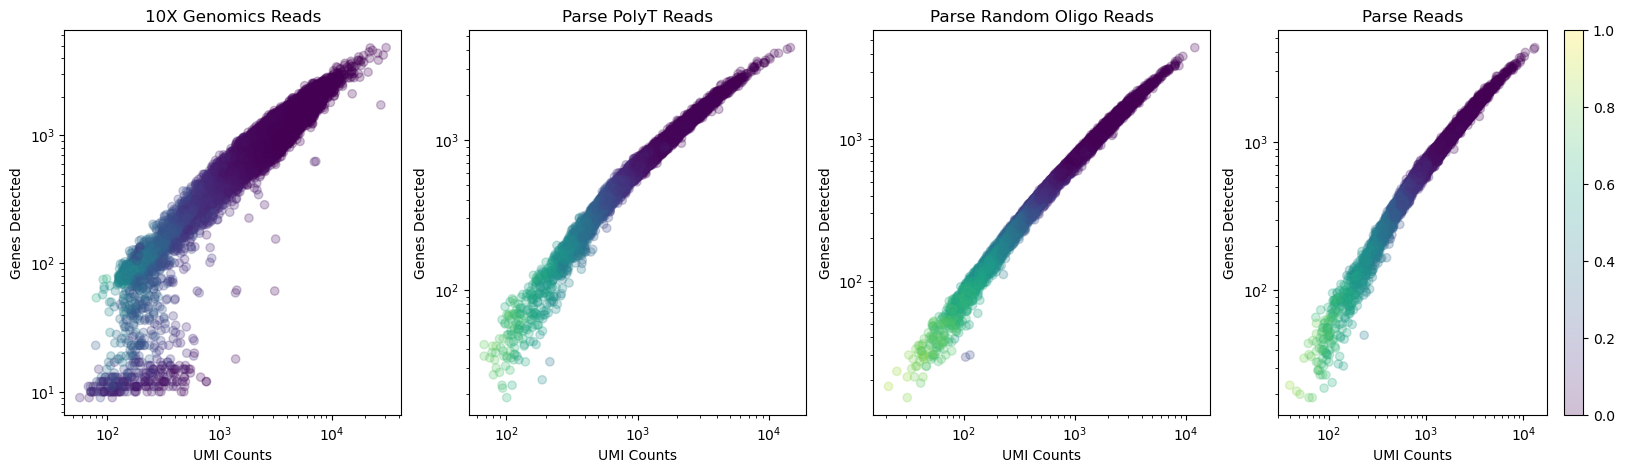

In [15]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs, datasets):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    im = ax.scatter(x, y, c=data.obs['background_fraction'], cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()

In [19]:
# Load anndata object and begin initial processing
def loadAnndata(data_name, data_title = None, modified = False):
    adatas = []
    for sample in samples:
        m_string = ""
        if modified:
            m_string = "_modified"

        dir = f"{outdir}sample_{data_name}_{sample}_out/"
        counts_dir = f"{dir}counts_unfiltered{m_string}/"

        # Read in h5ad file from kb-python alignment
        data = ad.read_h5ad(f"{counts_dir}adata.h5ad")
        data.obs['sample'] = sample
        
        # Add background fraction from cellbender output
        filename = f"{outdir}cellbender/{data_name}_{sample}.h5"
        with h5py.File(filename, "r") as f:
            cell_barcodes = [x.decode("utf-8") for x in f["metadata"]["barcodes_analyzed"][:]]
            bg_fraction = f["droplet_latents"]["background_fraction"][:]
            bg_df = pd.DataFrame({"background_fraction": bg_fraction}, index=cell_barcodes)
        data.obs = data.obs.join(bg_df, how="left")
        data.obs.fillna(1.0, inplace=True)
        adatas.append(data)
    
    adata = ad.concat(adatas, join='outer', index_unique=None)
    adata.uns['name'] = data_name
    adata.uns['title'] = data_title
    
    return adata

In [20]:
datasets = []
for name, title in zip(names, titles):
    datasets.append(loadAnndata(name, title, modified=(name=='parse')))

/home/mcaskey/miniconda3/envs/cellbender/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


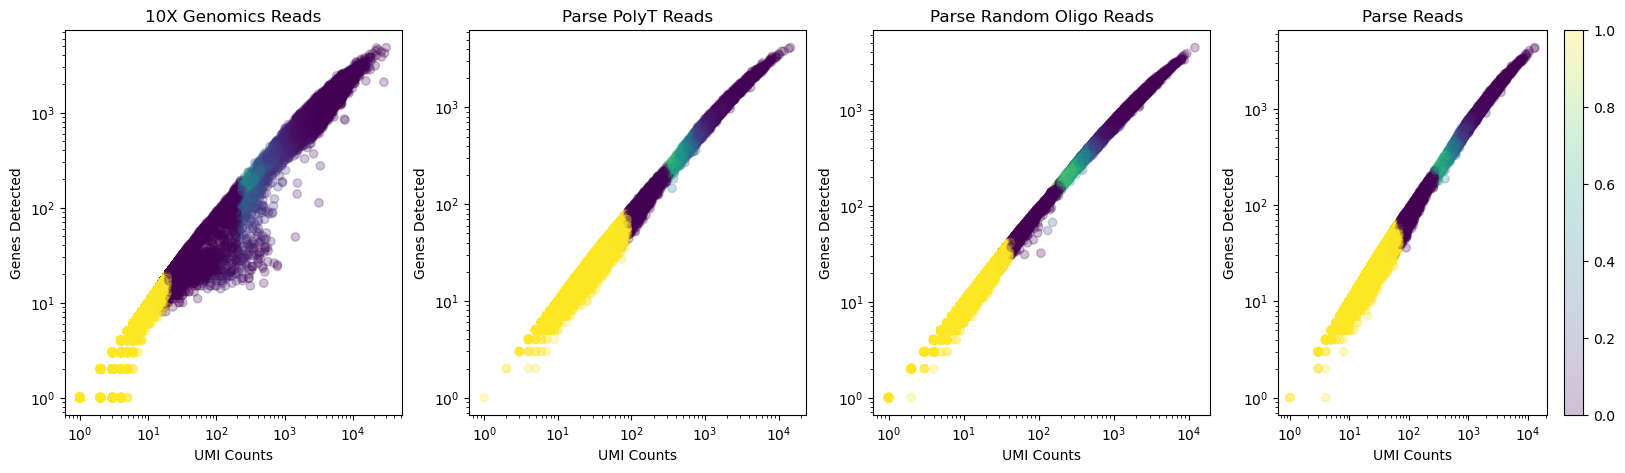

In [22]:
fig, axs = plt.subplots(1,4,figsize=(20, 5))

for ax, data in zip(axs, datasets):
    x = np.asarray(data.X.sum(axis=1))[:,0]
    y = np.asarray(np.sum(data.X>0, axis=1))[:,0]

    im = ax.scatter(x, y, c=data.obs['background_fraction'], cmap = 'viridis', alpha=0.25)
    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Genes Detected")
    ax.set_xscale('log')
    ax.set_yscale('log', nonpositive='clip')
    ax.set_title(data.uns['title']+" Reads")

fig.colorbar(im, ax=ax)

plt.show()